### Imports

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, roc_auc_score, roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_fscore_support, precision_recall_curve, RocCurveDisplay, fbeta_score
from sklearn.base import ClassifierMixin
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from raw_data import save_all_files, concat_df
from tqdm import tqdm
import pickle

# Load the data

Loads the required datasets from google cloud. Then selects only relevant columns and saves it into /data/_year_.pkl.

In [3]:
save_all_files()

Get a coffee ;) 


100%|██████████| 5/5 [00:00<00:00, 5001.55it/s]

You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You successfully downloaded 0 of the 5 files.


### Concatenate data from different years to one dataframe

In [4]:
df = concat_df()
df

100%|██████████| 12/12 [00:00<00:00, 82.89it/s]


,DIABETE3,SEX,_AGEG5YR,EDUCA,_BMI5,_BMI5CAT,GENHLTH,PHYSHLTH,_TOTINDA,EXERANY2,...,SMOKDAY2,_RFSMOK3,DRNKANY5,ALCDAY5,AVEDRNK2,DRNK3GE5,_RFBING5,CVDSTRK3,CVDINFR4,CVDCRHD4
0,3.0,2.0,9.0,4.0,1855.0,2.0,4.0,88.0,2.0,2.0,...,1.0,2.0,1.0,103.0,2.0,88.0,1.0,2.0,2.0,2.0
1,3.0,1.0,3.0,3.0,3529.0,4.0,4.0,12.0,2.0,2.0,...,1.0,2.0,9.0,NaN,NaN,NaN,9.0,2.0,2.0,2.0
2,3.0,2.0,14.0,6.0,1695.0,1.0,2.0,88.0,1.0,1.0,...,3.0,1.0,1.0,101.0,1.0,88.0,1.0,2.0,2.0,2.0
3,3.0,2.0,14.0,4.0,2579.0,3.0,3.0,88.0,9.0,NaN,...,NaN,1.0,9.0,NaN,NaN,NaN,9.0,2.0,2.0,2.0
4,4.0,2.0,7.0,3.0,4346.0,4.0,5.0,25.0,1.0,1.0,...,3.0,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380042,1.0,2.0,11.0,2.0,1842.0,1.0,4.0,88.0,2.0,2.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
2380043,3.0,2.0,2.0,5.0,2834.0,3.0,1.0,88.0,1.0,1.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
2380044,3.0,2.0,11.0,4.0,4110.0,4.0,4.0,88.0,9.0,NaN,...,3.0,1.0,1.0,202.0,2.0,88.0,1.0,2.0,2.0,2.0
2380045,3.0,1.0,7.0,5.0,2315.0,2.0,3.0,88.0,2.0,2.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0


# Data preparation

- feature selection
- data cleaning
- removing illegal input values and missing data
- renaming columns
- value mapping

In [5]:
# here the data cleaning and data preparation takes place
target_name = "DIABETE3"
feature_names = df.columns.values.tolist()
feature_names.remove(target_name)

# removed all nan values for decision tree to function
illegal_value_dict = {
    "SEX": [], 
    "_AGEG5YR": [14],
    "EDUCA": [9],
    "_BMI5": [], # nan (empty)
    "_BMI5CAT": [],
    "GENHLTH": [7, 9],
    "PHYSHLTH": [77, 88, 99],
    "_TOTINDA": [9],
    "EXERANY2": [7, 9],
    "SMOKE100": [7, 9],
    "SMOKDAY2": [7, 9],
    "_RFSMOK3": [9],
    "DRNKANY5": [7, 9],
   "ALCDAY5": [777, 999],
    "AVEDRNK2": [77, 99],
   "DRNK3GE5": [77, 99],
    "_RFBING5": [9],
    "CVDSTRK3": [7, 9],
    "CVDINFR4": [7, 9],
    "CVDCRHD4": [7, 9]
}

value_mapping = {
    "SEX": {1: 1, 2: 0}, # 1 = male, 0 = female
    # "_AGEG5YR": {},
    # "EDUCA": {}, # 1-6 ordinal categorical
    # "_BMI5": {}, # 1-999999
    # "_BMI5CAT": {}, # categorical
    # "GENHLTH": {}, # 1-5 ordinal categorical
    # "PHYSHLTH": {}, # 1-30
    "_TOTINDA": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "EXERANY2": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "SMOKE100": {1: 1, 2: 0}, # 1 = yes, 0 = no
    # "SMOKDAY2": {}, # 1 = "everyday", 2 = "some days", 3 = "not at all"
    "_RFSMOK3": {1: 0, 2: 1}, # 1 = yes, 0 = no
    "DRNKANY5": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "ALCDAY5": {888: 0, }, # categorical # TODO
    # "AVEDRNK2": {}, # 1-76 continuous
    "DRNK3GE5": {88: 0}, # 0-76 continuous
    "_RFBING5": {1: 0, 2: 1}, # 1 = yes, 0 = no
    "CVDSTRK3": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "CVDINFR4": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "CVDCRHD4": {1: 1, 2: 0} # 1 = yes, 0 = no
 }

feature_list = [
    "SEX", 
    "_AGEG5YR",
    "EDUCA", 
    "_BMI5", 
    "_BMI5CAT",
    "GENHLTH", 
    "PHYSHLTH",
    "_TOTINDA", 
    "EXERANY2", 
    "SMOKE100", 
    "SMOKDAY2", 
    "_RFSMOK3", 
    "DRNKANY5", 
    "ALCDAY5", 
    "AVEDRNK2", 
    "DRNK3GE5", 
    "_RFBING5", 
    "CVDSTRK3", 
    "CVDINFR4", 
    "CVDCRHD4"
]

renames = [
    "sex",
    "age",
   "education",
    "body_mass_index",
    "bmi_cat",
    "estimated_health",
    "bad_physhealth_days",
    "had_phys_activity",
    "any_exercise",
    "smoked_over_100",
    "smokes_daily",
    "is_smoker",
    "alcohol_past_30",
    "one_drink_per_day_month_last_30",
    "average_drinks",
    "more_than_5_drinks",
    "more_than_5_drinks_on_one_occasion",
    "had_stroke",
    "had_heart_attack",
    "had_angina"
]

exclude_cols = [
    'more_than_5_drinks',
    'average_drinks',
    'smokes_daily',
    'one_drink_per_day_month_last_30',
    'bmi_cat',
    'education'
]

# only include rows with diabetes = yes and no and select relevant columns
df_filtered = df.loc[df["DIABETE3"].isin([1, 3]), feature_list + [target_name]]

# filter out illegal values for each feature
for column, bad_value_list in tqdm(illegal_value_dict.items()):
    df_filtered = df_filtered[~df_filtered[column].isin(bad_value_list)]

# map values for each feature
for column, mapping in tqdm(value_mapping.items()):
    df_filtered[column] = df_filtered[column].map(mapping)

# rename label 1 = 1 = yes (has diabetes) | 3 = 0 = no (no diabetes)
df_filtered["DIABETE3"] = df_filtered["DIABETE3"].map({1: 1, 3: 0})
df_filtered.columns = renames + [target_name]
df_filtered

100%|██████████| 12/12 [00:00<00:00, 27.88it/s]


,sex,age,education,body_mass_index,bmi_cat,estimated_health,bad_physhealth_days,had_phys_activity,any_exercise,smoked_over_100,...,is_smoker,alcohol_past_30,one_drink_per_day_month_last_30,average_drinks,more_than_5_drinks,more_than_5_drinks_on_one_occasion,had_stroke,had_heart_attack,had_angina,DIABETE3
31,1,8.0,6.0,2585.0,3.0,2.0,2.0,1,1,1,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0
35,0,5.0,5.0,2391.0,2.0,4.0,5.0,0,0,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
36,0,5.0,5.0,3411.0,4.0,4.0,15.0,0,0,1,...,0,0,0.0,NaN,NaN,0,0,0.0,0,1
37,0,9.0,4.0,2575.0,3.0,4.0,20.0,0,0,1,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
39,0,11.0,5.0,2146.0,2.0,3.0,2.0,1,1,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380029,0,1.0,5.0,1785.0,1.0,3.0,4.0,1,1,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
2380032,1,9.0,4.0,3119.0,4.0,4.0,30.0,0,0,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
2380035,1,1.0,4.0,NaN,NaN,1.0,2.0,1,1,0,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0
2380039,1,3.0,6.0,4229.0,4.0,3.0,4.0,1,1,0,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0


### Final feature selection - removing exclude_cols

In [6]:

feature_list = [feature for feature in renames if feature not in exclude_cols]

df_filtered = df_filtered.loc[:, feature_list + [target_name]]

feature_list

['sex',
 'age',
 'body_mass_index',
 'estimated_health',
 'bad_physhealth_days',
 'had_phys_activity',
 'any_exercise',
 'smoked_over_100',
 'is_smoker',
 'alcohol_past_30',
 'more_than_5_drinks_on_one_occasion',
 'had_stroke',
 'had_heart_attack',
 'had_angina']

### Drop missing and bad input values

In [7]:
nan_amounts = [df_filtered[col].isnull().values.sum() for col in df_filtered.columns]
cols_with_nan_amounts = list(zip(df_filtered.columns, nan_amounts))
cols_with_nan_amounts.sort(key=lambda x: x[1], reverse=True)
cols_with_nan_amounts

[('body_mass_index', 31915),
 ('estimated_health', 11),
 ('bad_physhealth_days', 3),
 ('had_heart_attack', 1),
 ('sex', 0),
 ('age', 0),
 ('had_phys_activity', 0),
 ('any_exercise', 0),
 ('smoked_over_100', 0),
 ('is_smoker', 0),
 ('alcohol_past_30', 0),
 ('more_than_5_drinks_on_one_occasion', 0),
 ('had_stroke', 0),
 ('had_angina', 0),
 ('DIABETE3', 0)]

In [8]:
# drop na drops [NAN] of the rows...
df_prepared = df_filtered.dropna().reset_index(drop=True)

## Data Exploration

In [9]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704022 entries, 0 to 704021
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   sex                                 704022 non-null  int64  
 1   age                                 704022 non-null  float64
 2   body_mass_index                     704022 non-null  float64
 3   estimated_health                    704022 non-null  float64
 4   bad_physhealth_days                 704022 non-null  float64
 5   had_phys_activity                   704022 non-null  int64  
 6   any_exercise                        704022 non-null  int64  
 7   smoked_over_100                     704022 non-null  int64  
 8   is_smoker                           704022 non-null  int64  
 9   alcohol_past_30                     704022 non-null  int64  
 10  more_than_5_drinks_on_one_occasion  704022 non-null  int64  
 11  had_stroke                

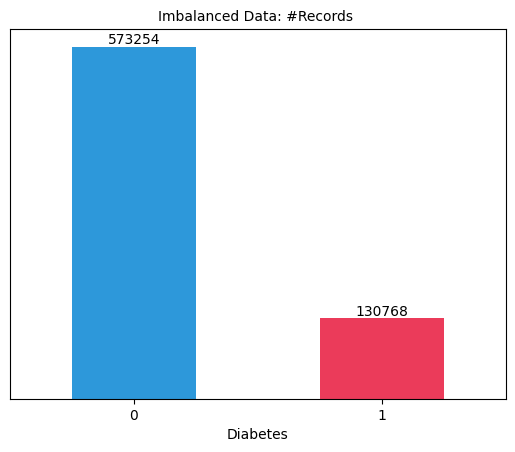

In [10]:
# viz imbalanced data
fontsize = 10
viz1 = df_prepared.DIABETE3.value_counts().plot(kind= "bar", rot = 0, color = ["#2d98da", "#eb3b5a"], fontsize = fontsize)
viz1.bar_label(viz1.containers[0], fontsize= fontsize)
plt.xlabel("Diabetes", fontsize=fontsize)
plt.ylabel("Count", fontsize= fontsize)
plt.title("Imbalanced Data: #Records ", fontsize = fontsize)

viz1.get_yaxis().set_visible(False)

The model will learn to classify "no Diabetes" better as there are more records in this class. Imbalanced data has consequences for further approach!

<Axes: xlabel='body_mass_index'>

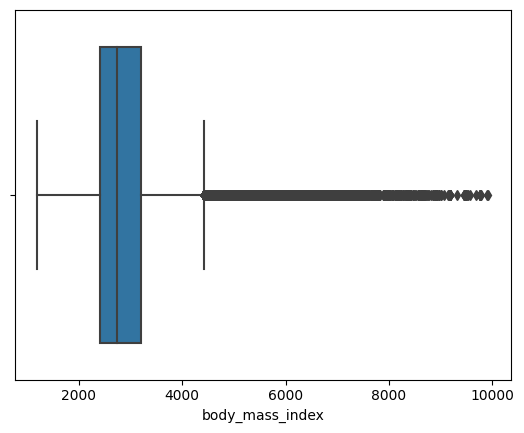

In [169]:
sns.boxplot(data = df_prepared, x="body_mass_index")

<Axes: xlabel='bad_physhealth_days', ylabel='count'>

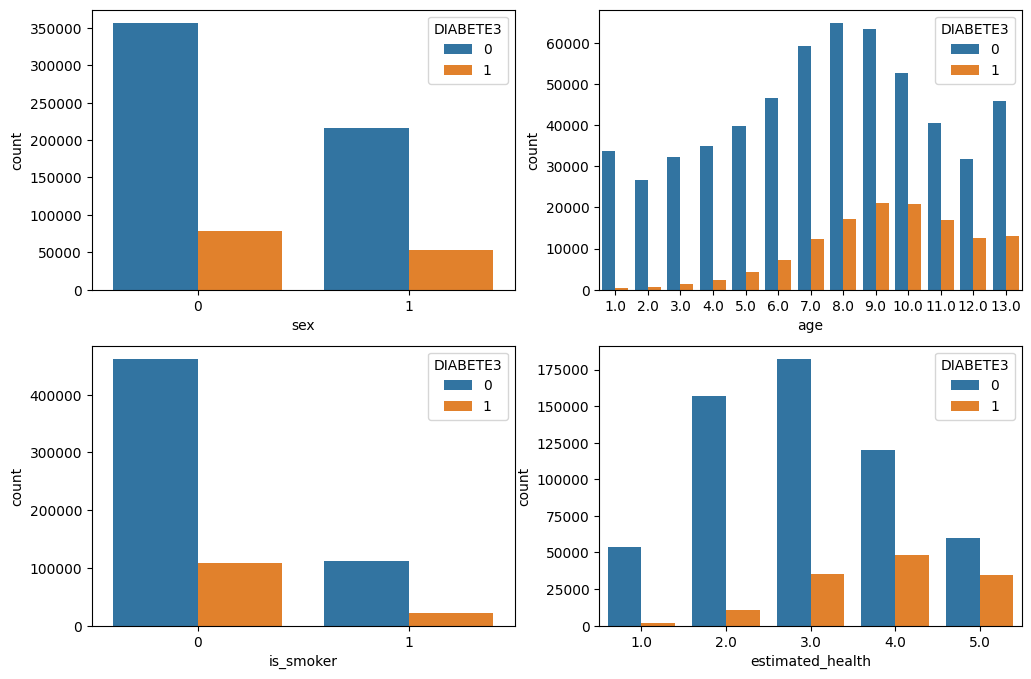

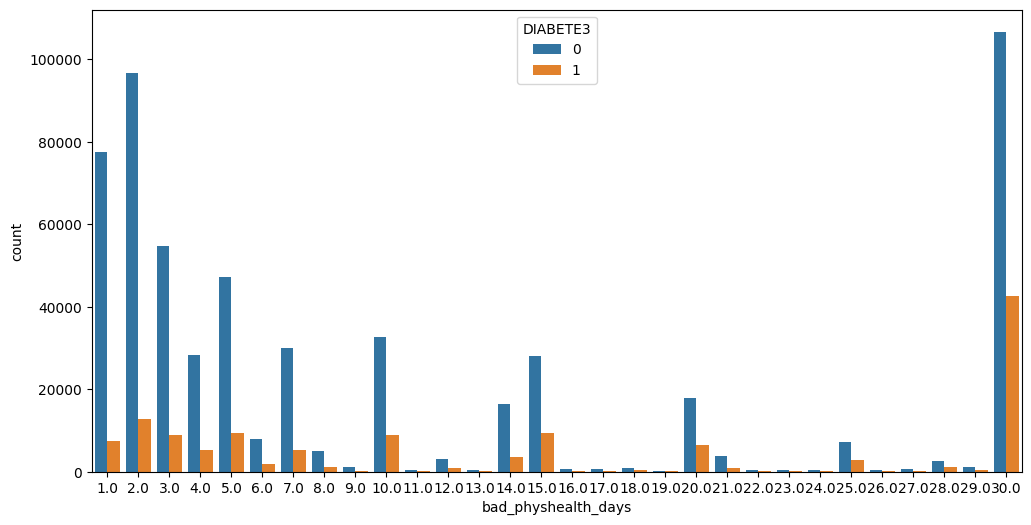

In [171]:
fig, ax =plt.subplots(2,2, figsize=(12,8))
sns.countplot(data = df_prepared, x="sex", hue="DIABETE3", ax= ax[0,0])
sns.countplot(data = df_prepared, x="age", hue="DIABETE3", ax= ax[0,1])
sns.countplot(data = df_prepared, x="is_smoker", hue="DIABETE3", ax= ax[1,0])
sns.countplot(data = df_prepared, x="estimated_health", hue="DIABETE3", ax= ax[1,1])
plt.figure(figsize= (12,6))
sns.countplot(data = df_prepared, x="bad_physhealth_days", hue="DIABETE3")

# Model training

### Compute the F-beta score 
... using precision and recall to mainly but not exclusively optimize for recall

see [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html):

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

... and [wikipedia](https://en.wikipedia.org/wiki/F-score):

Two commonly used values for β are 2, which weighs recall higher than precision, and 0.5, which weighs recall lower than precision.

In [11]:
# recall is X-times more important than precision
RECALL_IMPORTANCE_FACTOR = 1

In [12]:
def f_beta_score(precision, recall, beta=1):
    denominator = (beta**2 * precision) + recall
    numerator = precision * recall
    factor = 1 + beta**2 
    return factor * numerator / denominator


# defining threshold - any prediction with a probability greater than this threshold will be labelled as "has diabetes"
def optimize_threshold(y_true, y_scores, beta=1):
    # get the full precisin recall curve incl. thresholds - this can be used to for linear optimization using the f-beta-score defined above
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    df = pd.DataFrame(list(zip(precision, recall, thresholds)), columns=["precision", "recall", "threshold"])
    df["score"] = f_beta_score(precision=df.precision, recall=df.recall, beta=beta)
    best_row = df.loc[df["score"].idxmax()]
    return best_row


### Functions for evaluating and analysing a trained model

In [20]:
# function plotting all relevant graphs for each modeldd
# ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

def analyse_model(model: ClassifierMixin, X_test: pd.DataFrame, y_test: pd.Series, dummy_clf: DummyClassifier):

    # probability of having diabetes predicted by model
    y_proba = model.predict_proba(X_test)[:, 1]

    # same but using dummy classifier
    dummy_y_proba = dummy_clf.predict_proba(X_test)[:, 1]

    # go through a lot of different thresholds and find a compromize of recall/precision that satisfies our optimization function (custom f_beta score)
    optimal_threshold_row = optimize_threshold(y_test, y_proba, beta=RECALL_IMPORTANCE_FACTOR)

    print(f"----- Optimal threshold for this model according to F{RECALL_IMPORTANCE_FACTOR}-score -----")
    print(f"Best Threshold: {round(optimal_threshold_row.threshold, 4)}")

    # now use the optimized threshold for discrete prediction
    # binary labels predicted by model
    y_predict = (model.predict_proba(X_test)[:,1] >= optimal_threshold_row.threshold).astype(int)

    # same but with the dummy classifier
    dummy_y_predict = (dummy_clf.predict_proba(X_test)[:,1] >= optimal_threshold_row.threshold).astype(int)

    precision, recall, fbeta_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_predict, beta=RECALL_IMPORTANCE_FACTOR)

    # print recall for 1 = has diabetes for optimized threshold
    print(f"Achieved Precision: {round(precision[1] * 100, 4)} %")
    print(f"Achieved Recall: {round(recall[1] * 100, 4)} %")
    print(f"F{RECALL_IMPORTANCE_FACTOR}-score: {round(fbeta_score[1] * 100, 4)} %")

    
    # print AUC score
    auc_score = roc_auc_score(y_true=y_test, y_score=y_proba)
    print(f"----- AUC-score -----")
    print(auc_score)
    
    # model name used for plots
    model_name = type(model).__name__

    # display Confusionmatrix
    fig1 = plt.figure()
    ax1 = fig1.add_subplot()
    cfm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels=model.classes_, ax=ax1)

    # display precision_recall_curve
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax2, name=model_name) # add drawstyle="default" to make the curve smoother - but less accurate
    # pr_display_dummy = PrecisionRecallDisplay.from_predictions(y_test, dummy_y_proba, ax=ax2, name="DummyClassifier")
    # plt.legend(loc='upper right')

    # display ROC Curve
    fig3 = plt.figure()
    ax3 = fig3.add_subplot()
    roc_display = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_proba, ax=ax3, name=model_name)
    roc_display_dummy = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=dummy_y_proba, ax=ax3, name="DummyClassifier")


# function to train and analyse a model with given parameters
def evaluate_model(X_train, y_train, X_test, y_test, classifier: ClassifierMixin, params={}):

    model = classifier(**params)

    model.fit(X_train, y_train)

    # create dummy classifier for comparing performance
    dummy_clf = DummyClassifier(strategy="stratified")

    dummy_clf.fit(X_train, y_train)

    analyse_model(model, X_test, y_test, dummy_clf)

    return model

### Training function
- train-test-split
- initiate classifier model
- define custom scoring function to optimize f-beta-score
- RandomizedSearch with Stratified K Fold Crossvalidation using custom scorer
- training model
- optional: analyse best model from tuning phase together with baseline model

In [14]:
def get_best_parameters_for_model(df: pd.DataFrame, features: list, target: str, classifier: ClassifierMixin, param_distribution={}, n_iter=100, cv=5, make_analysis=True):
    
    # create custom scorer to use custom weights for recall and accuracy score during training
    custom_scorer = make_scorer(fbeta_score, beta=RECALL_IMPORTANCE_FACTOR)

    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=41)
    
    model = classifier(random_state=42)
    
    CV_model = RandomizedSearchCV(estimator=model, param_distributions=param_distribution, n_iter=n_iter, cv=cv, n_jobs=-1, scoring=custom_scorer, verbose=10)

    CV_model.fit(X_train, y_train)
    print("Model fitted successfully")

    # save model to a file
    filename = f"models/{type(CV_model.best_estimator_).__name__}.sav"
    pickle.dump(CV_model.best_estimator_, open(filename, 'wb'))

    if make_analysis:
        # create dummy classifier for comparing performance
        dummy_clf = DummyClassifier(strategy="most_frequent")

        dummy_clf.fit(X_train, y_train)

        analyse_model(CV_model.best_estimator_, X_test, y_test, dummy_clf)

    return X_train, y_train, X_test, y_test, CV_model

## Analysing Decision Tree Classifier

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model fitted successfully
----- Optimal threshold for this model according to F1.4-score -----
Best Threshold: 0.5932
Achieved Precision: 33.7545 %
Achieved Recall: 76.2344 %
F1.4-score: 53.4916 %
----- AUC-score -----
0.7792276618451373


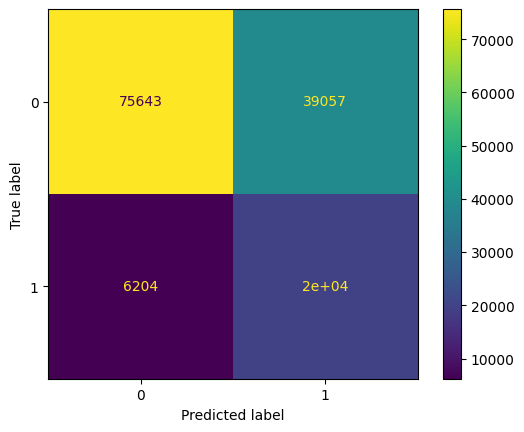

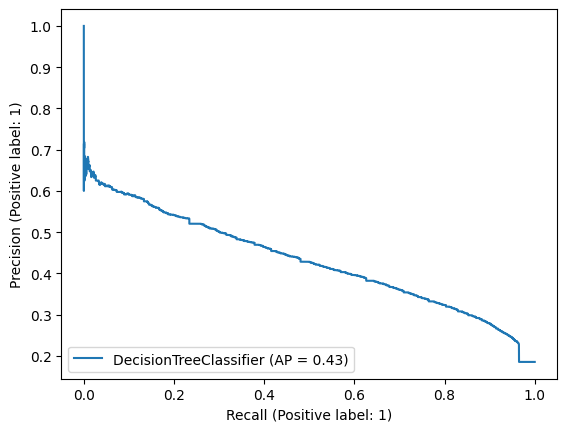

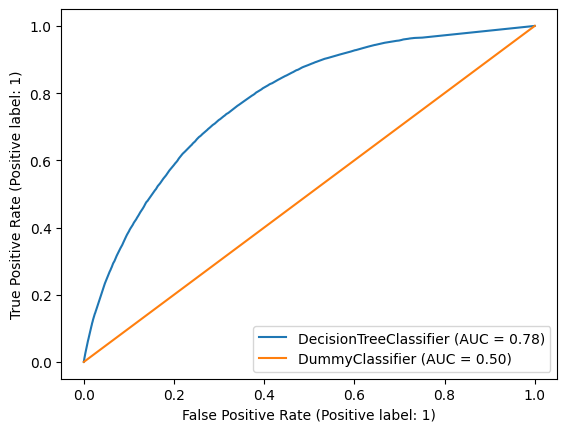

In [147]:
# find the best parameters from defined parameterspace for classifier
# source for values: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
param_distribution = {
    "splitter": ["best", "random"],
    "max_depth": np.arange(15, 40),
    "min_samples_split": np.arange(10, 40),
    "min_samples_leaf": np.arange(10, 35),
    # "min_weight_fraction_leaf": 0.0, 
    # "max_features": "sqrt",
    "min_impurity_decrease": np.arange(0, 0.03, 0.005),
    "class_weight": [
        # {0: 1, 1: 1},
        # {0: 1, 1: 2},
        {0: 1, 1: 4},
        {0: 1, 1: 5},
        {0: 1, 1: 6},
        {0: 1, 1: 7},
        {0: 1, 1: 8},
        # {0: 1, 1: 9},
        # {0: 1, 1: 10},
    ],
    "ccp_alpha": np.arange(0, 0.01, 0.001)
}

X_train, y_train, X_test, y_test, CV_model = get_best_parameters_for_model(df_prepared, feature_list, target_name, DecisionTreeClassifier, param_distribution)

## Analysing Random Forest Classifier

In [ ]:
# find the best parameters from defined parameterspace for classifier
# source for values: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
param_distribution = {
    "n_estimators": np.arange(120, 180, 10),
    "max_features": [None, 'sqrt', 'log2'],
    "max_depth": np.arange(2, 12, 1),
    "min_samples_split": np.arange(2, 6, 1),
    "min_samples_leaf": np.arange(2, 6),
    "bootstrap": [True, False],
    "ccp_alpha": np.arange(0, 0.03, 0.001),
    "class_weight": [
        # {0: 1, 1: 1},
        # {0: 1, 1: 2},
        {0: 1, 1: 4},
        {0: 1, 1: 5},
        {0: 1, 1: 6},
        {0: 1, 1: 7},
        {0: 1, 1: 8},
        # {0: 1, 1: 9},
        # {0: 1, 1: 10},
    ],
}

X_train, y_train, X_test, y_test, CV_model = get_best_parameters_for_model(df_prepared, feature_list, target_name, RandomForestClassifier, param_distribution, n_iter=30, cv=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model fitted successfully


## Analysing Logistic Regression Classifier

In [ ]:
# find the best parameters from defined parameterspace for classifier
# source for values: https://medium.com/@data.science.enthusiast/logistic-regression-tune-hyperparameters-python-code-fintech-does-it-bring-any-value-619e172565e6
param_distribution = {
    "solver": ['newton-cg', 'lbfgs'],# 'sag', 'liblinear'],
    "penalty": ['None', 'l2'], #'l1', 'elasticnet'],
    "C": np.arange(1,50,1)
}

X_train, y_train, X_test, y_test, CV_model = get_best_parameters_for_model(df_prepared, feature_list, target_name, LogisticRegression, param_distribution, n_iter=15)

## Load and analyse best model
Load preferred model for following user analysis:

In [17]:
CV_model = pickle.load(open(f"models/{model_name}.sav", 'rb'))
CV_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 130,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# load the best model from disk - see models directory and place name of file and respective model
# best model is RandomForestClassifier_best
model_name = "RandomForestClassifier_best"
classifier = RandomForestClassifier

CV_model = pickle.load(open(f"models/{model_name}.sav", 'rb'))

# create fresh train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_prepared[feature_list], df_prepared[target_name], test_size=0.2, random_state=41)

# retrain model with the best parameter configuration on train data
# train dummy model on train data
# analyse model and compare it to baseline/dummy model
model = evaluate_model(X_train, y_train, X_test, y_test, classifier=classifier, params=CV_model.get_params())

Optional: Learn about the models feature importances

In [27]:
feature_imp = list(zip(feature_list, model.feature_importances_))
feature_imp.sort(key=lambda x: x[1], reverse=True)
feature_imp

[('estimated_health', 0.39217732387931115),
 ('body_mass_index', 0.325698688399433),
 ('age', 0.18790204833958177),
 ('alcohol_past_30', 0.036540808668159966),
 ('had_heart_attack', 0.027549257872249842),
 ('had_angina', 0.02053638244021471),
 ('sex', 0.0035103824648195733),
 ('had_stroke', 0.0024830751962673175),
 ('bad_physhealth_days', 0.0016209191054628448),
 ('more_than_5_drinks_on_one_occasion', 0.0009152833091726025),
 ('is_smoker', 0.0005389647668878115),
 ('smoked_over_100', 0.0002550146192765345),
 ('had_phys_activity', 0.00013868074137917297),
 ('any_exercise', 0.00013317019778357565)]

# Use Model to predict user's diabetes probability

### Define functions for user input

In [31]:
question_names = [
    'sex',
    'age',
    'height',
    'weight',
    'estimated_health',
    'bad_physhealth_days',
    'had_phys_activity',
    'any_exercise',
    'smoked_over_100',
    'is_smoker',
    'alcohol_past_30',
    'more_than_5_drinks_on_one_occasion',
    'had_stroke',
    'had_heart_attack',
    'had_angina'
]

questions = [
    "What is your sex?",
    "What is your age?",
    "What is your height?",
    "What is your weight?",
    "Would you say that in general your health is:",
    "Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?",
    "Did you do any physical activity or exercise during the past 30 days other than your regular job?",
    "During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?",
    "Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]",
    "Are you currently a smoker?",
    "In the past 30 days did you have at least one drink of any alcoholic beverage such as beer, wine, a malt beverage or liquor?",
    "Considering all types of alcoholic beverages, during the past 30 days did you have 5 or more drinks for men or 4 or more drinks for women on at least one occasion?",
    "Did you ever have a stroke?",
    "Did you ever have a heart attack, also called a myocardial infarction?",
    "Did you ever have angina or coronary heart disease?",
]

answer_info = [
    "1 = male, 0 = female",
    "",
    "in cm",
    "in kg",
    '''
    1 Excellent
    2 Very good 
    3 Good 
    4 Fair
    5 Poor''',
    "0 - 30 Number of days",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
    "1 = yes, 0 = no",
]

answer_space = [
    {1, 0},
    set(range(18, 100)),
    set(range(1, 300)),
    set(range(1, 335)),
    {1, 2, 3, 4, 5},
    set(range(31)),
    {1, 0},
    {1, 0},
    {1, 0},
    {1, 0},
    {1, 0},
    {1, 0},
    {1, 0},
    {1, 0},
    {1, 0},
]

In [32]:
# transform some user input into correct input format
def transform_row(row):
    # calculate body_mass_index: WTKG3/(HTM4*HTM4) (Has 2 implied decimal places)
    row["body_mass_index"] = round(100 * row.pop("weight") / ((row.pop("height")/100)**2))
    
    # set age category
    age_categories = [
        (18, 24),
        (25, 29),
        (30, 34),
        (35, 39),
        (40, 44),
        (45, 49),
        (50, 54),
        (55, 59),
        (60, 64),
        (65, 69),
        (70, 74),
        (75, 79),
        (80, 84),
        (85, 89),
        (90, 94),
        (95, 99),
    ]

    for i, (start, end) in enumerate(age_categories):
        if row["age"] >= start and row["age"] <= end:
            row["age"] = i + 1
            break

    return row


# function that asks for user input using input() function and returns is as pd.Series 
def get_user_input() -> pd.Series:

    data_dict = {}

    for i, feature in enumerate(question_names):
        print(feature)
        print(answer_info[i])

        fails = 0
        max_fails = 10

        while True:
            try:
                # exit loop
                if fails >= max_fails:
                    return
                
                user_input = int(input(questions[i] + "    " + answer_info[i]))
                
                if user_input not in answer_space[i]:
                    print("Input not in valid range: " + str(answer_space[i]))
                    fails += 1
                    continue

                data_dict[feature] = user_input
                break

            except Exception as ex:
                print(ex)
                print("Invalid input, try again!")
                fails += 1
                continue
    # define order of features using feature_list defined on top
    ind = feature_list
    return pd.DataFrame([transform_row(data_dict)], columns=ind)

### Get user input
Provide user data via input mask

In [ ]:
# input data row as pd.Series
user_input_series = get_user_input()

In [34]:
# risk person example: 
at_risk = [[0, 10, 4518, 4, 25, 0, 0, 1, 1, 1, 1, 1, 1, 1]]
# healthy person example: 
healthy_person = [[1, 3, 2299, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0]]
user_input_series

In [35]:
# use trained model to predict_proba for user input
# threshold found after model training phase during analysis
picekd_threshold = 0.2605

user_row = user_input_series

probas = model.predict_proba(user_row)[0]

pred = (model.predict_proba(user_row)[:,1] >= picekd_threshold).astype(int)

print(probas)

[0.99472691 0.00527309]


c:\Users\Nick\.virtualenvs\diabetes-forecasting-G7uteuiX\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nick\.virtualenvs\diabetes-forecasting-G7uteuiX\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Make recommendation
What factors have the most significant impact on the user's diabetes probability?

In [42]:
print("The following predictions are not always 100% correct. When in doubt, seek advice by a healthcare professional!")
print("")
print("######################################")
print("#############   RESULT   #############")
print("######################################")
print("")

if pred[0] == 0:
    print("Considering your input you are currently not at risk of getting diabetes.")
if pred[0] == 1:
    print("You are at risk of getting diabetes. Please contact a doctor or take a test.")

The following predictions are not always 100% correct. When in doubt, seek advice by a healthcare professional!

######################################
#############   RESULT   #############
######################################

Considering your input you are currently not at risk of getting diabetes.
